In [4]:
import torch
import torchvision
import os

In [3]:
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np 
import pandas as pd 
import seaborn as sn 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 

In [8]:
transform = transforms.ToTensor()

Load CIFAR10 Dataset

In [11]:
train_data = datasets.CIFAR10(
    root=os.path.join(os.getcwd(), 'data'),
    train=True,
    download=True,
    transform=transform
)
test_data = datasets.CIFAR10(
    root=os.path.join(os.getcwd(), 'data'),
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


Create Loaders

In [12]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader  = DataLoader(test_data , batch_size=10, shuffle=True)

In [14]:
# Define labels
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

View some images

Label:  [3 5 9 1 5 4 6 4 5 8]
Class:  ['  cat' '  dog' 'truck' '  car' '  dog' ' deer' ' frog' ' deer' '  dog'
 ' ship']
Shape of images:  torch.Size([10, 3, 32, 32])


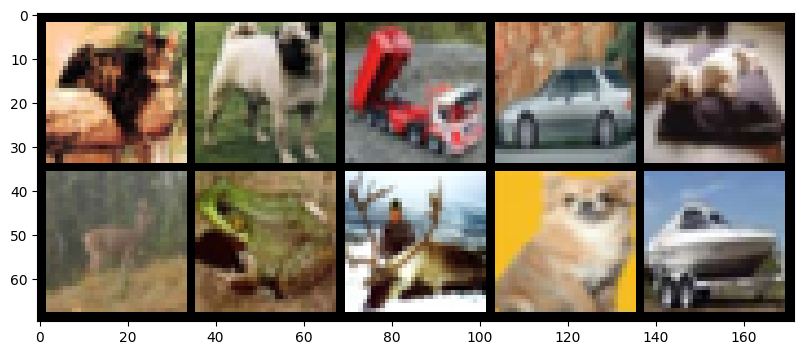

In [24]:
for images, labels in train_loader:
    break

print('Label: ', labels.numpy())
print('Class: ', np.array([class_names[i] for i in labels]))

# Print images
print('Shape of images: ', images.shape)
im = make_grid(images, nrow=5)
plt.figure(figsize=(10, 4))
# plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
plt.imshow(np.transpose(im, (1, 2, 0)))


Cuda

In [25]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    
    return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    
    return data.to(device, non_blocking=True)

class ToDeviceLoader:
    def __init__(self, data, device):
        self.data = data
        self.device = device

    def __iter__(self):
        for batch in self.data:
            yield to_device(batch, self.device)
        
    def __len__(self):
        return len(self.data)

In [26]:
device = get_device()
train_loader = ToDeviceLoader(train_loader, device)
test_loader = ToDeviceLoader(test_loader, device)

In [27]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)   
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [28]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model.cuda()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
import time
start_time = time.time()
epochs = 30
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # Total the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted==y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.50964141  accuracy:  41.650%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.41658139  accuracy:  44.095%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.77979159  accuracy:  45.733%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.16000307  accuracy:  47.000%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 0.96437961  accuracy:  47.926%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.24104762  accuracy:  54.400%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.50528097  accuracy:  54.450%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.20811510  accuracy:  54.500%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.12787843  accuracy:  55.050%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 0.77221441  accuracy:  55.362%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 0.94807565  accuracy:  58.940%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 0.94470596  accuracy:  59.145%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 0.87049913  accuracy:  59.040%
epoch:  2  b

In [36]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        # self.layer10 = nn.Sequential(
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size = 2, stride = 2))
        # self.layer11 = nn.Sequential(
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU())
        # self.layer12 = nn.Sequential(
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU())
        # self.layer13 = nn.Sequential(
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            # nn.Linear(7*7*512, 4096),
            nn.Linear(4*4*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(256,10)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        # out = self.layer10(out)
        # out = self.layer11(out)
        # out = self.layer12(out)
        # out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return F.log_softmax(out, dim=1)

In [37]:
torch.manual_seed(101)
model1 = VGG16()
model1.cuda()

VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr = 0.001)

In [39]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model1(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model1(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:  0  batch: 1000 [ 10000/50000]  loss: 3.07693338  accuracy:  16.870%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 2.04445124  accuracy:  18.835%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 2.57492757  accuracy:  20.863%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 2.02547956  accuracy:  23.038%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.08514190  accuracy:  25.420%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.10631442  accuracy:  40.330%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.33038425  accuracy:  42.155%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.91171575  accuracy:  44.603%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.35304761  accuracy:  47.017%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.80070150  accuracy:  49.122%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 0.97965068  accuracy:  60.620%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 0.83021176  accuracy:  61.900%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.23387051  accuracy:  62.783%
epoch:  2  b